In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pong

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pydot

# tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [4]:
SEQ_LEN = 128
W, H = 40, 40

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
import sys
sys.path.append('../DilatedRNN/models')

from classification_models import _contruct_cells, _rnn_reformat
from drnn import multi_dRNN_with_dilations

In [33]:
class Model:
    INTERNAL_SIZE = 32

    def project_game_init(self, x):
        if not hasattr(self, 'project_state'):
            self.project_state = tf.keras.layers.Dense(
                Model.INTERNAL_SIZE,
                name='project_state',
                activation='tanh'
            )

            self.project_activation = tf.keras.layers.Dense(
                Model.INTERNAL_SIZE,
                name='project_activation',
                activation='tanh'
            )

        return self.project_state(x), self.project_activation(x)

    def __init__(self):
        game_init = tf.keras.layers.Input(shape=(1), name='game_init', batch_size=32)
        user_input = tf.keras.layers.Input(shape=(SEQ_LEN, 2), name='user_input', batch_size=32)

        self.memory = tf.keras.layers.LSTM(
            Model.INTERNAL_SIZE,
            return_sequences=True,
            name='memory',
            activation='tanh'
        )

        c, a = self.project_game_init(game_init)
        initialized_ui = self.memory(user_input, initial_state=[c, a])
        
        print(initialized_ui)

        # DRNN
        hidden_structs = [Model.INTERNAL_SIZE] * 2
        dilations = [2, 4]
        x_reformat = _rnn_reformat(initialized_ui, Model.INTERNAL_SIZE, SEQ_LEN)
        cells = _contruct_cells(hidden_structs, 'LSTM')
        drnn_logits = multi_dRNN_with_dilations(cells, x_reformat, dilations)

        self.renderer = tf.keras.layers.Reshape((-1, W, H), name='frames')(
            tf.keras.layers.Dense(W * H, activation='sigmoid')
        )

        frames = self.renderer(drnn_logits)

        self.net = tf.keras.Model([game_init, user_input], [frames])

        self.net.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['mse', 'accuracy']
        )

In [34]:
model = Model()

Tensor("memory_9/transpose_1:0", shape=(32, 128, 32), dtype=float32)
Building layer: multi_dRNN_dilation_2, input length: 128, dilation rate: 2, input dim: 32.
=====> Input length for sub-RNN: 64


ValueError: An `initial_state` was passed that is not compatible with `cell.state_size`. Received `state_spec`=ListWrapper([InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2), InputSpec(shape=(64, 32), ndim=2)]); however `cell.state_size` is [32, 32]

In [26]:
# tf.keras.utils.plot_model(model.net, to_file='model.png')

In [29]:
class PlotCallback(tf.keras.callbacks.Callback):
    def plot_pairwise_frames():
        frame_nums = [1, 4, 8, 16, 32, 64, 127]

        X, Y = list(make_dataset(1).take(1))[0]
        (directions, controls), (frames, game_over) = X, Y
        pred_frames, _ = model.net.predict([directions, controls])

        plot_size = 2
        num_imgs = len(frame_nums)
        fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

        for i, f in enumerate(frame_nums):
            l, r = (axs[0, i], axs[1, i])

            l.imshow(frames[0, f], cmap='bwr')
            r.imshow(pred_frames[0, f], cmap='bwr')

            l.set_xticklabels([])
            r.set_xticklabels([])
            l.set_yticklabels([])
            r.set_yticklabels([])

        fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    def on_epoch_begin(self, batch, logs=None):
        self.plot_pairwise_frames()
        plt.show()

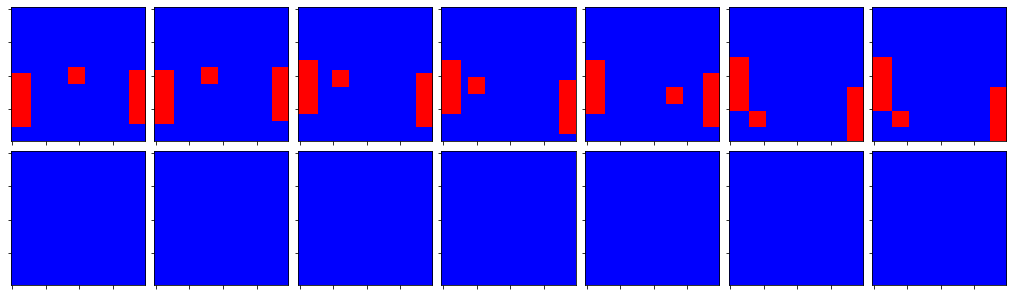

Epoch 1/2500


KeyboardInterrupt: 

In [31]:
input_generator = make_dataset(bs=32)

model.net.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=2,
    steps_per_epoch=100,
    epochs=2500,
    callbacks=[PlotCallback()]
)

In [13]:
training_loss = model.net.history.history['loss']
test_loss = model.net.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

KeyError: 'loss'

In [ ]:
plot_pairwise_frames(frame_nums)

In [ ]:
stateful = model.copy_in_stateful_model()
stateful.init(0.4)
t = 0

stateful.net.save('STATEFUL_LSTM3_PONG_RELU_VARIED_INPUT.hdf5')

In [ ]:
t += 1
frame, _ = stateful.single_step_predict([-1, 1])

plt.imshow(frame > 0.01)
t